In [12]:
import tensorflow as tf
import numpy as np

In [13]:
# 加载数据集:
(train_image, train_label), (test_image, test_label) = tf.keras.datasets.fashion_mnist.load_data()
type(train_image)

numpy.ndarray

In [14]:
train_image.shape

(60000, 28, 28)

此时原始数据都是3为数组，但是**CNN的输入只认图片数据**！图片的格式都是**4维数组**！（总张图, 高, 宽, 通道数） —— 因此需要人为在最后补一维！下面3种方式可完全替换，效果一样：
- numpy方法1：np.expand_dims(train_image, -1)
- numpy方法2：train_image.reshape(60000, 28, 28, 1)
- tf方法：tf.expand_dims(train_image, -1) —— 返回结果直接是Tensor！前两个都还是ndarray

In [15]:
#  最后一维加个通道：
train_image = np.expand_dims(train_image, -1)
test_image = np.expand_dims(test_image, -1)
train_image.shape

(60000, 28, 28, 1)

# 模型搭建

In [17]:
model = tf.keras.Sequential()

注意：
- 卷积层也是需要激活的，直接在层里完成即可；
- 第一隐藏层都是要写明input_shape的（单位元素的尺寸）！—— ANN、CNN等必须得有
- 卷积核的数量，一般都是$2^{n}$，且往后递增！

In [18]:
# 卷积层1：
model.add( tf.keras.layers.Conv2D(32, (3,3), input_shape=(28,28,1), activation = 'relu') )  # 默认不padding！
model.output_shape

(None, 26, 26, 32)

In [19]:
# 池化层1：图片变小，相当于同样大小的卷积核的“感受野”在变大 —— 没有要训练的参数！
model.add( tf.keras.layers.MaxPooling2D() )
model.output_shape

(None, 13, 13, 32)

In [20]:
# 卷积层2：填充，图片大小不变！
model.add( tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same' ) )
model.output_shape

(None, 13, 13, 64)

In [21]:
# 全局展平层：每个通道求一个平均（每张特征图求出一个平均值，即每个特征有一个均值数代替！） —— 64个
model.add( tf.keras.layers.GlobalAveragePooling2D() )
model.output_shape

(None, 64)

In [22]:
# 全连接层：10分类
model.add( tf.keras.layers.Dense(10, activation = 'softmax') )
model.output_shape

(None, 10)

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                650       
Total params: 19,466
Trainable params: 19,466
Non-trainable params: 0
_________________________________________________________________


待训练参数多少的计算：
- 卷积层1：(3*3 + 1)*32 = 320
- 池化层1（最大值池化）：没有需要训练的参数
- 卷积层2：比较复杂的组合搭配，远大于(3*3 + 1)*64=640！
- 池化层2（全局均值池化）：没有需要训练的参数
- 全连接层：(64 + 1)*10 = 650

# 训练与优化

In [25]:
# 编译：
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',  # 顺序编码
    metrics = ['acc']
)

In [26]:
history = model.fit( train_image, train_label, epochs = 5, validation_data = (test_image, test_label) )

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 34s 572us/sample - loss: 0.7959 - acc: 0.7372 - val_loss: 0.5822 - val_acc: 0.7999
Epoch 2/5
60000/60000 [==============================] - 33s 546us/sample - loss: 0.4965 - acc: 0.8268 - val_loss: 0.4971 - val_acc: 0.8280
Epoch 3/5
60000/60000 [==============================] - 32s 535us/sample - loss: 0.4342 - acc: 0.8468 - val_loss: 0.4508 - val_acc: 0.8393
Epoch 4/5
60000/60000 [==============================] - 32s 529us/sample - loss: 0.3974 - acc: 0.8597 - val_loss: 0.4094 - val_acc: 0.8608
Epoch 5/5
60000/60000 [==============================] - 32s 530us/sample - loss: 0.3693 - acc: 0.8688 - val_loss: 0.3861 - val_acc: 0.8642


In [27]:
# 绘图：
import matplotlib.pyplot as plt

In [30]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

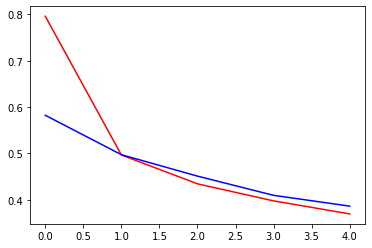

In [31]:
# loss变化对比：
plt.plot(history.epoch, history.history.get('loss'), c = 'r', label = 'loss')
plt.plot(history.epoch, history.history.get('val_loss'), c = 'b', label = 'val_loss')

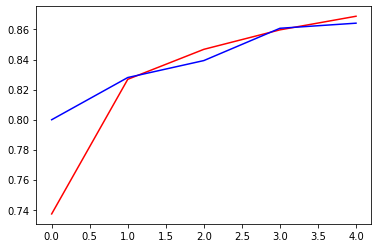

In [32]:
# acc变化对比：
plt.plot(history.epoch, history.history.get('acc'), c = 'r', label = 'acc')
plt.plot(history.epoch, history.history.get('val_acc'), c = 'b', label = 'val_acc')

改进网络策略：和之前讲的一样
- 增加卷积层数、每个卷积层的卷积核数也增加（最主要提取特征的方式！）；
- 在“**卷积池化**”的组合中，可以每次多**几个连续的卷积层（提高拟合能力！）**，最后加一个池化层！
- 适量增多池化层，增大下一卷积层中卷积核的感受野！
- 配着加一些dropout层，一般加在池化层后：model.add(tf.keras.layers.Dropout(0.5))
- 全连接层也多加一些

总之：优化的策略只要大体方向正确即可，没有具体的要求。